In [2]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend" # https://github.com/plaidml/plaidml/blob/master/docs/index.md

from keras.models import Model, save_model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout # Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
#from keras.preprocessing.image import load_img, img_to_array # requires pip install pillow / import PIL

# keras version still end up import tf.keras version which is incompatible, import directly instead
from tensorflow.keras.callbacks import TensorBoard

Using plaidml.keras.backend backend.


In [3]:
# https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/
# Conv2D(batch_size, (input_shape), activation, padding) # more batch size in deeper layer
# MaxPooling2D((input_shape), padding) # padding 'valid' = no padding, padding 'same' = preserve dimension + padding

model_version = 'v9' # getting tired or renaming everytime
dropout_pct = 0.2
input_shape = (128, 128, 3)
encoded_shape = (16, 16, 16)

'''
# Autoencoder Architecture
input_img = Input(shape=input_shape) # change this to other than 28*28 may show "multiple" shape
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(dropout_pct)(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(dropout_pct)(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x) # check model.summary() for shape

x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Dropout(dropout_pct)(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Dropout(dropout_pct)(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x) # may want to intentionally drop padding here for other shape
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder Model
autoencoder = Model(input_img, decoded, name='autoencoder')
autoencoder.compile(optimizer='adam', loss='binary_crossentropy') # use binary_crossentropy, mean_squared_error doesnt work
autoencoder.run_eagerly = True # plaidml / keras not running eager mode by default

# Encoder Architecture
Elayer_input = Input(shape=input_shape) # layer start from 0
x = autoencoder.layers[1](Elayer_input)
x = autoencoder.layers[2](x)
x = autoencoder.layers[4](x)
x = autoencoder.layers[5](x)
x = autoencoder.layers[7](x)
Elayer_output = autoencoder.layers[8](x) # extract middle layer

# Encoder Model
encoder = Model(Elayer_input, Elayer_output, name='encoder')

# Decoder Architecture
Dlayer_input = Input(shape=encoded_shape) # use model.summary() to check input_shape
x = autoencoder.layers[-9](Dlayer_input)
x = autoencoder.layers[-8](x)
x = autoencoder.layers[-6](x)
x = autoencoder.layers[-5](x)
x = autoencoder.layers[-3](x)
x = autoencoder.layers[-2](x)
Dlayer_output = autoencoder.layers[-1](x) # extract last layer, start from -1

# Decoder Model
decoder = Model(Dlayer_input, Dlayer_output, name='decoder')

# Remove unused variable to reduce RAM usage
del x, input_img, encoded, decoded, Elayer_input, Elayer_output, Dlayer_input, Dlayer_output
'''

'\n# Autoencoder Architecture\ninput_img = Input(shape=input_shape) # change this to other than 28*28 may show "multiple" shape\nx = Conv2D(64, (3, 3), activation=\'relu\', padding=\'same\')(input_img)\nx = MaxPooling2D((2, 2), padding=\'same\')(x)\nx = Dropout(dropout_pct)(x)\nx = Conv2D(32, (3, 3), activation=\'relu\', padding=\'same\')(x)\nx = MaxPooling2D((2, 2), padding=\'same\')(x)\nx = Dropout(dropout_pct)(x)\nx = Conv2D(16, (3, 3), activation=\'relu\', padding=\'same\')(x)\nencoded = MaxPooling2D((2, 2), padding=\'same\')(x) # check model.summary() for shape\n\nx = Conv2D(16, (3, 3), activation=\'relu\', padding=\'same\')(encoded)\nx = UpSampling2D((2, 2))(x)\nx = Dropout(dropout_pct)(x)\nx = Conv2D(32, (3, 3), activation=\'relu\', padding=\'same\')(x)\nx = UpSampling2D((2, 2))(x)\nx = Dropout(dropout_pct)(x)\nx = Conv2D(64, (3, 3), activation=\'relu\', padding=\'same\')(x) # may want to intentionally drop padding here for other shape\nx = UpSampling2D((2, 2))(x)\ndecoded = Con

In [4]:
'''
# way too much training parameters, dense is too exhaustive and little benefit even though simple
autoencoder.summary()
encoder.summary()
decoder.summary()
'''

'\n# way too much training parameters, dense is too exhaustive and little benefit even though simple\nautoencoder.summary()\nencoder.summary()\ndecoder.summary()\n'

In [5]:
def make_square(img):
    cols,rows = img.size
    
    if rows>cols:
        pad = (rows-cols)/4
        img = img.crop((0, pad, cols, cols+pad)) # left, up, right, down
    else:
        pad = (cols-rows)/4
        img = img.crop((pad, 0, rows+pad, rows))
    
    return img # make centered square image

In [6]:
%%time
target_length_size = 128
#target_image_size = (target_length_size, target_length_size)

# Check training dataset image # no longer needed
'''
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display

path_train = r'D:\Public\fyp-code\datasets\coco\train2017-2'

train_data = []

for img in sorted(os.listdir(path_train)):
    #print(img) # show which image file currently used
    
    # Keras builtin (not used)
    #x = load_img(os.path.join(path_train,img), target_size=(128,128), color_mode='grayscale') 
    #x = img_to_array(x)
    
    # PIL (use this)
    x = Image.open(os.path.join(path_train,img))
    display(x) # show training image
    print('Original image size is ' + str(x.size))
    x = make_square(x)
    display(x) # show square image
    print('Squared image size is ' + str(x.size))
    x = x.resize(target_length_size) # TAKE NOTE
    x = np.asarray(x)
    x = x.astype('float32')/255
    train_data.append(np.asarray(x)) # can take a long time
    print(str(len(train_data)) + ' of ' + str(len(os.listdir(path_train))))
    break

print('train_data type is ' + str(type(train_data)))
print('train_data shape is '+ str(np.asarray(train_data).shape)) # type list has no shape, must be in type array # (1, 128, 128, 3)
print('image type in train_data is ' + str(type(train_data[0])))
plt.imshow(np.squeeze(train_data[0])) # show resized 1st image
plt.show()

# Remove unused variable to reduce RAM usage
del x
'''

Wall time: 0 ns


"\nimport os\nimport numpy as np\nimport matplotlib.pyplot as plt\nfrom PIL import Image\nfrom IPython.display import display\n\npath_train = r'D:\\Public\x0cyp-code\\datasets\\coco\train2017-2'\n\ntrain_data = []\n\nfor img in sorted(os.listdir(path_train)):\n    #print(img) # show which image file currently used\n    \n    # Keras builtin (not used)\n    #x = load_img(os.path.join(path_train,img), target_size=(128,128), color_mode='grayscale') \n    #x = img_to_array(x)\n    \n    # PIL (use this)\n    x = Image.open(os.path.join(path_train,img))\n    display(x) # show training image\n    print('Original image size is ' + str(x.size))\n    x = make_square(x)\n    display(x) # show square image\n    print('Squared image size is ' + str(x.size))\n    x = x.resize(target_length_size) # TAKE NOTE\n    x = np.asarray(x)\n    x = x.astype('float32')/255\n    train_data.append(np.asarray(x)) # can take a long time\n    print(str(len(train_data)) + ' of ' + str(len(os.listdir(path_train))))\

In [7]:
# Refer "Dataset Preprocess to Pickle - COCO train2017.ipynb" for data preprocess
# We will directly load preprocessed datasets rather than load jpg one by one

In [ ]:
%%time
import pickle as pkl

with open(f'datasets_coco_train2017_{target_length_size}.pkl', 'rb') as handle:
    print(f'Opening datasets_coco_train2017_{target_length_size}.pkl')
    train_data = pkl.load(handle)
    print('Done')

with open(f'datasets_coco_test2017_{target_length_size}.pkl', 'rb') as handle:
    print(f'Opening datasets_coco_test2017_{target_length_size}.pkl')
    test_data = pkl.load(handle)
    print('Done')

with open(f'datasets_coco_val2017_{target_length_size}.pkl', 'rb') as handle:
    print(f'Opening datasets_coco_val2017_{target_length_size}.pkl')
    val_data = pkl.load(handle)
    print('Done')

Opening datasets_coco_train2017_128.pkl


In [ ]:
%%time
#train_data = np.reshape(train_data, (len(train_data), 128, 128, 3))
#test_data = np.reshape(test_data, (len(test_data), 128, 128, 3))
#val_data = np.reshape(val_data, (len(val_data), 128, 128, 3))
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

In [ ]:
%%time
# we need to flatten images for basic neural network input
#train_data = train_data.reshape(len(train_data), (np.prod(train_data.shape[1:]))) # 64x64 flatten into 12288
#test_data  = test_data.reshape(len(test_data), (np.prod(test_data.shape[1:])))

print(f'train_data shape = {train_data.shape}') # 14785 images 12288 vectors = 14785 row 12288 col
print(f'test_data shape = {test_data.shape}') # 5083 images 12288 vectors = 5083 row 12288 col

In [ ]:
%%time
# in case the result is bad, try checkout the last best possible network

# Resume by load model (example)
autoencoder = load_model(f'autoencoder{model_version}/model/autoencoder{model_version}-best.h5') # use this
#latest = tf.train.latest_checkpoint(f'autoencoder{model_version}/checkpoint') # TODO

# Encoder Architecture
Elayer_input = Input(shape=input_shape) # layer start from 0
x = autoencoder.layers[1](Elayer_input)
x = autoencoder.layers[2](x)
x = autoencoder.layers[4](x)
x = autoencoder.layers[5](x)
x = autoencoder.layers[7](x)
Elayer_output = autoencoder.layers[8](x) # extract middle layer

# Encoder Model
encoder = Model(Elayer_input, Elayer_output, name='encoder')

# Decoder Architecture
Dlayer_input = Input(shape=encoded_shape) # use model.summary() to check input_shape
x = autoencoder.layers[-9](Dlayer_input)
x = autoencoder.layers[-8](x)
x = autoencoder.layers[-6](x)
x = autoencoder.layers[-5](x)
x = autoencoder.layers[-3](x)
x = autoencoder.layers[-2](x)
Dlayer_output = autoencoder.layers[-1](x) # extract last layer, start from -1

# Decoder Model
decoder = Model(Dlayer_input, Dlayer_output, name='decoder')

# Remove unused variable to reduce RAM usage
del x, Elayer_input, Elayer_output, Dlayer_input, Dlayer_output

autoencoder.summary()
encoder.summary()
decoder.summary()

In [ ]:
%%time
'''
import os

try:
    os.makedirs(f'autoencoder{model_version}/logs')
except Exception:
    pass

try:
    os.makedirs(f'autoencoder{model_version}/checkpoint')
except Exception:
    pass

# Run this in a terminal (unfortunate cant rename this one on the fly)
#tensorboard --logdir=autoencoderv9/logs

callbacks=[
    TensorBoard(log_dir=f'autoencoder{model_version}/logs'),
    ModelCheckpoint(filepath=f'autoencoder{model_version}/checkpoint' + '/' + 'model.{epoch:003d}-{val_loss:.4f}.h5',
                    verbose=1, save_best_only=True, mode='min'),
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10) # patience=10
]

initial_epoch = 0 # set this to something else if want to resume training

# Fit data # If it takes a long time to show Epoch 1, check your input shape # WARINING: RAM will rise
training = autoencoder.fit(train_data, train_data,
                           validation_data=(test_data, test_data),
                           epochs=100, batch_size=50, shuffle=True, initial_epoch=initial_epoch,
                           callbacks=callbacks)

print(CURRENT_TIME)
'''

In [ ]:
%%time
'''
import os

try:
    os.makedirs(f'autoencoder{model_version}/model')
except Exception:
    pass

save_model(autoencoder, f'autoencoder{model_version}/model/autoencoder{model_version}-last_train.h5')
save_model(encoder, f'autoencoder{model_version}/model/encoder{model_version}-last_train.h5')
save_model(decoder, f'autoencoder{model_version}/model/decoder{model_version}-last_train.h5')
'''

In [ ]:
%%time
'''
# need to put training = autoencoder.fit(...) first
import matplotlib.pyplot as plt

plt.plot(training.history['loss'], label='train')
plt.plot(training.history['val_loss'], label='test')
plt.show()
'''

In [12]:
%%time

#val_data  = val_data.reshape(len(val_data), (np.prod(val_data.shape[1:])))
print(f'val_data shape = {val_data.shape}')

encoded_imgs = encoder.predict(val_data)
decoded_imgs = decoder.predict(encoded_imgs)

print(f'encoded_imgs shape = {encoded_imgs.shape}')
print(f'decoded_imgs shape = {decoded_imgs.shape}')

val_data shape = (625, 128, 128, 3)


INFO:plaidml:Analyzing Ops: 21 of 28 operations complete
INFO:plaidml:Analyzing Ops: 28 of 45 operations complete


encoded_imgs shape = (625, 16, 16, 16)
decoded_imgs shape = (625, 128, 128, 3)
Wall time: 27.7 s


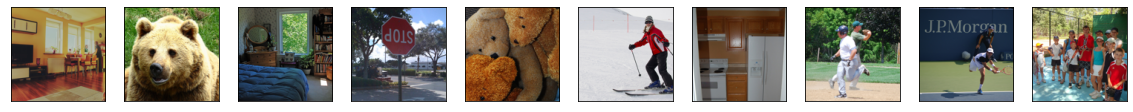

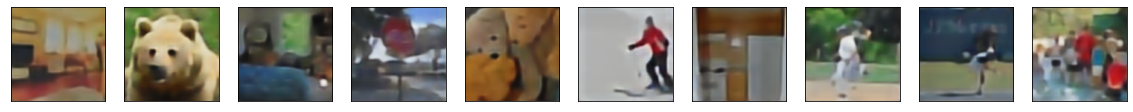

MSE = 0.0063, PSNR (dB) = 22.03
MSE = 0.0105, PSNR (dB) = 19.77
MSE = 0.0073, PSNR (dB) = 21.37
MSE = 0.0114, PSNR (dB) = 19.44
MSE = 0.0049, PSNR (dB) = 23.13
MSE = 0.0223, PSNR (dB) = 16.52
MSE = 0.0051, PSNR (dB) = 22.89
MSE = 0.0119, PSNR (dB) = 19.25
MSE = 0.0070, PSNR (dB) = 21.53
MSE = 0.0146, PSNR (dB) = 18.35
Wall time: 1.62 s


In [13]:
%%time
# result of training with dropout after maxpool and upsample and test them with dropouts removed
import matplotlib.pyplot as plt # use plt.gray() for grayscale, default is viridis
import numpy as np
import math
import cv2

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(val_data[i].reshape(input_shape))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(decoded_imgs[i].reshape(input_shape))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

# https://dsp.stackexchange.com/questions/38065/peak-signal-to-noise-ratio-psnr-in-python-for-an-image
def mse(img1, img2):
    return np.mean( (img1 - img2) ** 2 )

def psnr(img1, img2):
    mserr = mse(img1, img2)
    PIXEL_MAX = 1.0
    try:
        return 20 * math.log10(PIXEL_MAX / math.sqrt(mserr))
    except ZeroDivisionError:
        return 'Same image'

n = 10
for i in range(n):
    original = val_data[i]
    contrast = decoded_imgs[i]
    a = mse(original, contrast)
    b = psnr(original, contrast) # can also use cv2.PSNR rather than defined function psnr
    if b != 'Same image':
        print(f'MSE = {a:.4f}, PSNR (dB) = {b:.2f}')
    else:
        print(f'MSE = {a:.4f}, PSNR too high')

In [1]:
%%time
# https://github.com/imamun93/Image-Similarities-using-SSIM/blob/master/blog5_ssim.ipynb
import numpy as np
from tensorflow.image import ssim
from tensorflow import convert_to_tensor

n = 10
for i in range(n):
    original = val_data[i].reshape(1, 128, 128, 3)
    contrast = decoded_imgs[i].reshape(1, 128, 128, 3)
    a = np.asarray(ssim(convert_to_tensor(original), convert_to_tensor(contrast), max_val=1)) # <class 'tensorflow.python.framework.ops.EagerTensor'>
    print(f'SSIM = {a[0]:.4f}')

NameError: name 'val_data' is not defined

In [15]:
%%time
# https://github.com/tensorflow/models/blob/master/research/compression/image_encoder/msssim.py
import numpy as np
from scipy import signal
from scipy.ndimage.filters import convolve

def _FSpecialGauss(size, sigma):
  """Function to mimic the 'fspecial' gaussian MATLAB function."""
  radius = size // 2
  offset = 0.0
  start, stop = -radius, radius + 1
  if size % 2 == 0:
    offset = 0.5
    stop -= 1
  x, y = np.mgrid[offset + start:stop, offset + start:stop]
  assert len(x) == size
  g = np.exp(-((x**2 + y**2)/(2.0 * sigma**2)))
  return g / g.sum()


def _SSIMForMultiScale(img1, img2, max_val=255, filter_size=11,
                       filter_sigma=1.5, k1=0.01, k2=0.03):
  """Return the Structural Similarity Map between `img1` and `img2`.
  This function attempts to match the functionality of ssim_index_new.m by
  Zhou Wang: http://www.cns.nyu.edu/~lcv/ssim/msssim.zip
  Arguments:
    img1: Numpy array holding the first RGB image batch.
    img2: Numpy array holding the second RGB image batch.
    max_val: the dynamic range of the images (i.e., the difference between the
      maximum the and minimum allowed values).
    filter_size: Size of blur kernel to use (will be reduced for small images).
    filter_sigma: Standard deviation for Gaussian blur kernel (will be reduced
      for small images).
    k1: Constant used to maintain stability in the SSIM calculation (0.01 in
      the original paper).
    k2: Constant used to maintain stability in the SSIM calculation (0.03 in
      the original paper).
  Returns:
    Pair containing the mean SSIM and contrast sensitivity between `img1` and
    `img2`.
  Raises:
    RuntimeError: If input images don't have the same shape or don't have four
      dimensions: [batch_size, height, width, depth].
  """
  if img1.shape != img2.shape:
    raise RuntimeError('Input images must have the same shape (%s vs. %s).',
                       img1.shape, img2.shape)
  if img1.ndim != 4:
    raise RuntimeError('Input images must have four dimensions, not %d',
                       img1.ndim)

  img1 = img1.astype(np.float64)
  img2 = img2.astype(np.float64)
  _, height, width, _ = img1.shape

  # Filter size can't be larger than height or width of images.
  size = min(filter_size, height, width)

  # Scale down sigma if a smaller filter size is used.
  sigma = size * filter_sigma / filter_size if filter_size else 0

  if filter_size:
    window = np.reshape(_FSpecialGauss(size, sigma), (1, size, size, 1))
    mu1 = signal.fftconvolve(img1, window, mode='valid')
    mu2 = signal.fftconvolve(img2, window, mode='valid')
    sigma11 = signal.fftconvolve(img1 * img1, window, mode='valid')
    sigma22 = signal.fftconvolve(img2 * img2, window, mode='valid')
    sigma12 = signal.fftconvolve(img1 * img2, window, mode='valid')
  else:
    # Empty blur kernel so no need to convolve.
    mu1, mu2 = img1, img2
    sigma11 = img1 * img1
    sigma22 = img2 * img2
    sigma12 = img1 * img2

  mu11 = mu1 * mu1
  mu22 = mu2 * mu2
  mu12 = mu1 * mu2
  sigma11 -= mu11
  sigma22 -= mu22
  sigma12 -= mu12

  # Calculate intermediate values used by both ssim and cs_map.
  c1 = (k1 * max_val) ** 2
  c2 = (k2 * max_val) ** 2
  v1 = 2.0 * sigma12 + c2
  v2 = sigma11 + sigma22 + c2
  ssim = np.mean((((2.0 * mu12 + c1) * v1) / ((mu11 + mu22 + c1) * v2)))
  cs = np.mean(v1 / v2)
  return ssim, cs


def MultiScaleSSIM(img1, img2, max_val=255, filter_size=11, filter_sigma=1.5,
                   k1=0.01, k2=0.03, weights=None):
  """Return the MS-SSIM score between `img1` and `img2`.
  This function implements Multi-Scale Structural Similarity (MS-SSIM) Image
  Quality Assessment according to Zhou Wang's paper, "Multi-scale structural
  similarity for image quality assessment" (2003).
  Link: https://ece.uwaterloo.ca/~z70wang/publications/msssim.pdf
  Author's MATLAB implementation:
  http://www.cns.nyu.edu/~lcv/ssim/msssim.zip
  Arguments:
    img1: Numpy array holding the first RGB image batch.
    img2: Numpy array holding the second RGB image batch.
    max_val: the dynamic range of the images (i.e., the difference between the
      maximum the and minimum allowed values).
    filter_size: Size of blur kernel to use (will be reduced for small images).
    filter_sigma: Standard deviation for Gaussian blur kernel (will be reduced
      for small images).
    k1: Constant used to maintain stability in the SSIM calculation (0.01 in
      the original paper).
    k2: Constant used to maintain stability in the SSIM calculation (0.03 in
      the original paper).
    weights: List of weights for each level; if none, use five levels and the
      weights from the original paper.
  Returns:
    MS-SSIM score between `img1` and `img2`.
  Raises:
    RuntimeError: If input images don't have the same shape or don't have four
      dimensions: [batch_size, height, width, depth].
  """
  if img1.shape != img2.shape:
    raise RuntimeError('Input images must have the same shape (%s vs. %s).',
                       img1.shape, img2.shape)
  if img1.ndim != 4:
    raise RuntimeError('Input images must have four dimensions, not %d',
                       img1.ndim)

  # Note: default weights don't sum to 1.0 but do match the paper / matlab code.
  weights = np.array(weights if weights else
                     [0.0448, 0.2856, 0.3001, 0.2363, 0.1333])
  levels = weights.size
  downsample_filter = np.ones((1, 2, 2, 1)) / 4.0
  im1, im2 = [x.astype(np.float64) for x in [img1, img2]]
  mssim = np.array([])
  mcs = np.array([])
  for _ in range(levels):
    ssim, cs = _SSIMForMultiScale(
        im1, im2, max_val=max_val, filter_size=filter_size,
        filter_sigma=filter_sigma, k1=k1, k2=k2)
    mssim = np.append(mssim, ssim)
    mcs = np.append(mcs, cs)
    filtered = [convolve(im, downsample_filter, mode='reflect')
                for im in [im1, im2]]
    im1, im2 = [x[:, ::2, ::2, :] for x in filtered]
  return (np.prod(mcs[0:levels-1] ** weights[0:levels-1]) *
          (mssim[levels-1] ** weights[levels-1]))

n = 10
for i in range(n):
    original = val_data[i].reshape(1, 128, 128, 3)
    contrast = decoded_imgs[i].reshape(1, 128, 128, 3)
    d=MultiScaleSSIM(original, contrast, max_val=1)
    print(f'MSSIM = {d:.4f}')

0.8422
0.8599
0.7812
0.8275
0.8280
0.8593
0.8583
0.8017
0.8326
0.7710
Wall time: 601 ms


(128, 128, 3)


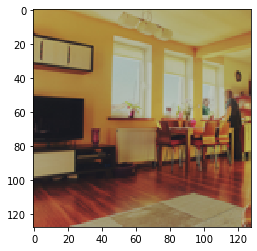

(128, 384)


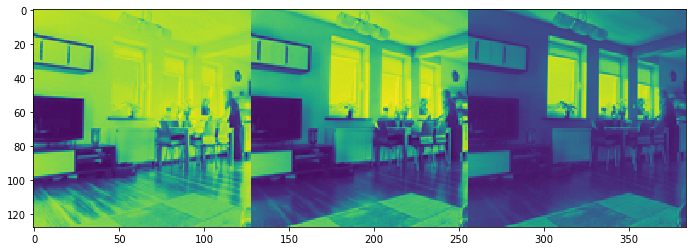

(16, 16, 16)


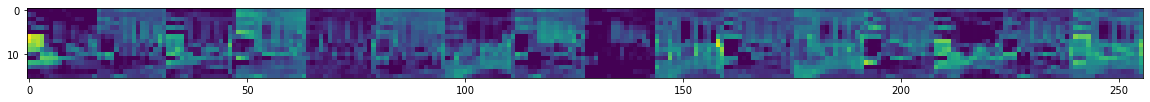

(128, 128, 3)


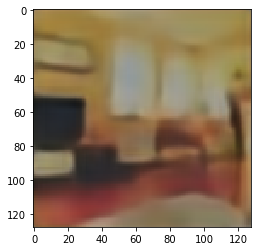

MSE = 0.0063, PSNR (dB) = 22.03, SSIM = 0.6625, MSSIM = 0.8422


In [70]:
# Test the data here, run the rest first

from matplotlib import pyplot as plt

i = 0 # val_data[i]

plt.figure(figsize=(20, 4))
print(val_data[i].shape)
plt.imshow(val_data[i], interpolation='nearest')
plt.show()

# test transpose
plt.figure(figsize=(20, 4))
print(val_data[i].T.reshape(128*3,128).T.shape)
#plt.imshow(val_data[i].T, interpolation='nearest') # TypeError: Invalid shape (3, 128, 128) for image data
#plt.show()
#plt.imshow(val_data[i].T.reshape(128*3,128), interpolation='nearest')
#plt.show()
plt.imshow(val_data[i].T.reshape(128*3,128).T, interpolation='nearest') # RGB
plt.show()

plt.figure(figsize=(20, 4))
print(encoded_imgs[i].shape)
plt.imshow(encoded_imgs[i].T.reshape(16 * 16, 16).T, interpolation='nearest') # height * depth, width
plt.show()

plt.figure(figsize=(20, 4))
print(decoded_imgs[i].shape)
plt.imshow(decoded_imgs[i], interpolation='nearest')
plt.show()

# Run the rest first
a = mse(val_data[i], decoded_imgs[i])
b = psnr(val_data[i], decoded_imgs[i])
ori_reshape = val_data[i].reshape(1, 128, 128, 3)
cmp_reshape = decoded_imgs[i].reshape(1, 128, 128, 3)
c = np.asarray(ssim(convert_to_tensor(ori_reshape), convert_to_tensor(cmp_reshape), max_val=1))
d = MultiScaleSSIM(ori_reshape, cmp_reshape, max_val=1)
print(f'MSE = {a:.4f}, PSNR (dB) = {b:.2f}, SSIM = {c[0]:.4f}, MSSIM = {d:.4f}')

In [ ]:
'''
%%time
# in case the result is bad, try checkout the last best possible network

# Resume by load model (example)
#autoencoder = load_model(f'autoencoder{model_version}/checkpoint/model.004-0.644.h5') # use this
#latest = tf.train.latest_checkpoint(f'autoencoder{model_version}/checkpoint') # TODO

# Encoder Architecture
Elayer_input = Input(shape=input_shape) # layer start from 0
x = autoencoder.layers[1](Elayer_input)
x = autoencoder.layers[2](x)
x = autoencoder.layers[4](x)
x = autoencoder.layers[5](x)
x = autoencoder.layers[7](x)
Elayer_output = autoencoder.layers[8](x) # extract middle layer

# Encoder Model
encoder = Model(Elayer_input, Elayer_output, name='encoder')

# Decoder Architecture
Dlayer_input = Input(shape=encoded_shape) # use model.summary() to check input_shape
x = autoencoder.layers[-9](Dlayer_input)
x = autoencoder.layers[-8](x)
x = autoencoder.layers[-6](x)
x = autoencoder.layers[-5](x)
x = autoencoder.layers[-3](x)
x = autoencoder.layers[-2](x)
Dlayer_output = autoencoder.layers[-1](x) # extract last layer, start from -1

# Decoder Model
decoder = Model(Dlayer_input, Dlayer_output, name='decoder')

# Remove unused variable to reduce RAM usage
del x, Elayer_input, Elayer_output, Dlayer_input, Dlayer_output

encoded_imgs = encoder.predict(val_data)
decoded_imgs = decoder.predict(encoded_imgs)
'''
'''
autoencoder.summary()
encoder.summary()
decoder.summary()
'''
'''
%%time
# result here
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2

n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(val_data[i].reshape(input_shape))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(input_shape))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

# https://dsp.stackexchange.com/questions/38065/peak-signal-to-noise-ratio-psnr-in-python-for-an-image
def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

n = 10
for i in range(n):
    original = val_data[i]
    contrast = decoded_imgs[i]
    d=psnr(original,contrast) # can also use cv2.PSNR rather than defined function psnr
    print('%.1f' % d)
'''

In [ ]:
%%time
# conclusion: ?
'''
import os

try:
    os.makedirs(f'autoencoder{model_version}/model')
except Exception:
    pass

save_model(autoencoder, f'autoencoder{model_version}/model/autoencoder{model_version}-best.h5')
save_model(encoder, f'autoencoder{model_version}/model/encoder{model_version}-best.h5')
save_model(decoder, f'autoencoder{model_version}/model/decoder{model_version}-best.h5')
'''

In [11]:
autoencoder = load_model(f'autoencoder{model_version}/model/autoencoder{model_version}-best.h5')
encoder = load_model(f'autoencoder{model_version}/model/encoder{model_version}-best.h5')
decoder = load_model(f'autoencoder{model_version}/model/decoder{model_version}-best.h5')

INFO:plaidml:Opening device "opencl_intel_hd_graphics_4000.0"
d:\public\fyp-code\plaidml\.venv\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
